# Generation of a Nanowire Network

We wish to simulate a nanowire network.

Assume each nanowire is a line in two-dimensional space. Any two touching nanowires forms a junction that acts something like a memristor.

First, define nanowires and junctions. Nanowires will be defined by their vertices given in units of micrometers on a global coordinate system. All the nanowires of one simulated network will be stored in a list. Junctions will reference nanowires by indexing into this list. Nanowires, likewise, will reference into a similar list of junctions.

During the simulation, each nanowire will have one fixed voltage. Junctions will show much more complex behavior.

In [2]:
import math
import random
import matplotlib.pyplot as pyplot
import matplotlib.patches as patches
import numpy
import scipy.fftpack

class Nanowire:

    def __init__(self, start, end):
        self.x1, self.y1 = start
        self.x2, self.y2 = end
        self.voltage = 0
        self.junctions = []

class Junction:

    def __init__(self, position, start, end, ron, roffron, wmax, mobility, dissolution_rate, roffron_sigma, wmax_sigma, alpha_sigma, w0=0.5):
        
        # topological characteristics
        self.x, self.y = position
        self.nanowires = [start, end]
        
        # physical characteristics
        self.current = 0 # current from start to end nanowire
        self.ron = ron; self.roff = ron*random.gauss(roffron, roffron*roffron_sigma) # resistance of switch on and off states (ohm)
        self.wmax = random.gauss(wmax, wmax*wmax_sigma) # current width and maximum width of ionic bridge (m)
        self.w = self.wmax*w0 # current width of junction
        self.mobility = mobility # ionic mobility (m^2/(s*V))
        self.dissolution_rate = dissolution_rate; # rate of dissolution of bridge (1/s)
        self.alpha_sigma = alpha_sigma # standard deviation of noise as fraction of dw/dt
        self.last_dwdt=0
        
    def resistance(self):
        return (self.ron*(self.w/self.wmax) + self.roff*(1-self.w/self.wmax))
    
    def dwdt(self):
        self.last_dwdt = self.mobility*self.ron/self.wmax*self.current*(self.w*(self.wmax-self.w)/(self.wmax**2)) - self.dissolution_rate*(self.w) + random.gauss(0, self.last_dwdt*self.alpha_sigma)
        return self.last_dwdt
    
    def update_w(self, timestep):
        self.w += self.dwdt()*timestep
        if self.w < 0:
            self.w = 0
        if self.w > self.wmax:
            self.w = self.wmax

Next, create a routine to generate nanowires, then test it.

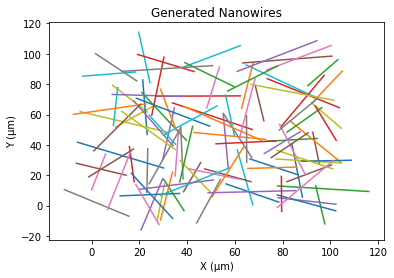

In [3]:
"""
Creates a set of nanowires, randomly and uniformly positioned within the given constraints, and returns the set as a list.

num_nanowires : the number of nanowires to create
xmin / xmax / ymin / ymax : the bounding box, in units of micrometers, of the centerpoints of the nanowires
lmin / lmax : the minimum and maximum allowed lengths of the nanowires, respectively
seed : seed to initialize the random number generator
"""
def spawn_nanowires(num_nanowires=100, xmin=0, xmax=100, ymin=0, ymax=100, lmin=20, lmax=40, seed=1):
    nanowires = [] # will store nanowires
    random.seed(seed) # be kinda deterministic
    
    for i in range(num_nanowires):

        # Generate nanowire start and end points.
        # Note that center of nanowire is inside boundary:
        # the nanowire can rotate to leave boundary---
        # if this were not allowed, one would have an abnormal
        # buildup of nanowires parallel to and next to each wall.
        new_length = random.uniform(lmin, lmax)
        new_angle =  random.uniform(0, math.pi)
        new_dxmax =  math.cos(new_angle)*new_length/2
        new_dymax =  math.sin(new_angle)*new_length/2
        new_dxmin = -math.cos(new_angle)*new_length/2
        new_dymin = -math.sin(new_angle)*new_length/2
        new_x     =  random.uniform(xmin, xmax)
        new_y     =  random.uniform(ymin, ymax)
        new_start =  new_x+new_dxmin, new_y+new_dymin
        new_end   =  new_x+new_dxmax, new_y+new_dymax

        nanowires.append(Nanowire(new_start, new_end))
    
    return nanowires
        
# test network creation

network = spawn_nanowires()

for nanowire in network:
    pyplot.plot([nanowire.x1, nanowire.x2], [nanowire.y1, nanowire.y2])
pyplot.title("Generated Nanowires")
pyplot.xlabel("X (µm)")
pyplot.ylabel("Y (µm)")
pyplot.show()

Good; that seems to work.

Now, create a routine to find all junctions of a network, and test it.

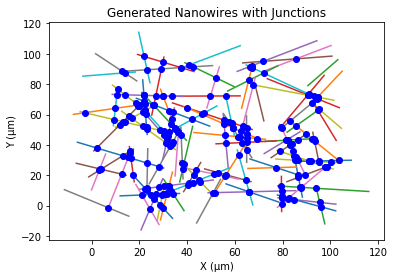

In [16]:
def create_junctions(network, electrodes=[], ron=5e3, roffron=1e3, wmax=5e-9, mobility=0.5e-12, dissolution_rate=1e-1, roffron_sigma=0, wmax_sigma=0, alpha_sigma=0, w0=0.5, seed=1):
    """Given array of Nanowire, returns array of junctions and correspondingly updates Nanowire array objects."""
    junctions = [] # will store junctions
    
    random.seed(seed) # be kinda deterministic

    for i, nanowire in enumerate(network):
        # obtain min and max coordinates for bouding box
        nxmin = min(nanowire.x1, nanowire.x2); nymin = min(nanowire.y1, nanowire.y2)
        nxmax = max(nanowire.x1, nanowire.x2); nymax = max(nanowire.y1, nanowire.y2)
        # and get start and end points (not necessarily the min/max box corners) with shorter names
        nx1 = nanowire.x1; ny1 = nanowire.y1
        nx2 = nanowire.x2; ny2 = nanowire.y2
        for j, other in enumerate(network):
            if j <= i: # avoid duplicate comparisons
                continue
            # as before...
            oxmin = min(other.x1, other.x2); oxmax = max(other.x1, other.x2)
            oymin = min(other.y1, other.y2); oymax = max(other.y1, other.y2)
            ox1 = other.x1; oy1 = other.y1
            ox2 = other.x2; oy2 = other.y2
            # first compare bouding boxes of nanowires for a collision
            if nxmax >= oxmin and nxmin <= oxmax:
                if nymax >= oymin and nymin <= oymax:
                    # if there is an intersection, find its location
                    if nx2 == nx1: # prevent division by zero
                        nx2 = nx1+1e-10
                    if ox2 == ox1: # ~
                        ox2 = ox1+1e-10
                    nslope = (ny2-ny1)/(nx2-nx1)
                    oslope = (oy2-oy1)/(ox2-ox1)
                    if nslope == oslope: # prevent division by zero
                        nslope = oslope+1e-10
                    intx = (nx1*nslope-ny1-ox1*oslope+oy1)/(nslope-oslope)
                    inty = (nx1*nslope*oslope-ny1*oslope-(ox1*oslope-oy1)*nslope)/(nslope-oslope)
                    # if the intersection is still within the bounding boxes, it's a junction!
                    if nxmin <= intx <= nxmax and nymin <= inty <= nymax:
                        if oxmin <= intx <= oxmax and oymin <= inty <= oymax:
                            on_same_electrode = False
                            for electrode in electrodes: # ignore the junction if nanowires are connected to same electrode
                                if i in electrode.nanowires and j in electrode.nanowires:
                                    on_same_electrode = True
                            if not on_same_electrode:
                                network[i].junctions.append(len(junctions))
                                network[j].junctions.append(len(junctions))
                                first = i; second = j
                                if random.choice([True, False]): # randomize polarity of junction
                                    first = j; second = i
                                junctions.append(Junction((intx, inty), first, second, ron=ron, roffron=roffron, wmax=wmax, mobility=mobility,
                                                          dissolution_rate=dissolution_rate, roffron_sigma=roffron_sigma, wmax_sigma=wmax_sigma, alpha_sigma=alpha_sigma, w0=w0))
    
    return junctions

network = spawn_nanowires()
junctions = create_junctions(network)
for nanowire in network:
    pyplot.plot([nanowire.x1, nanowire.x2], [nanowire.y1, nanowire.y2])
for junction in junctions:
    pyplot.plot([junction.x], [junction.y], 'bo')
pyplot.title("Generated Nanowires with Junctions")
pyplot.xlabel("X (µm)")
pyplot.ylabel("Y (µm)")
pyplot.show()

Later, we will need to simulate electrodes attached to the network. Let these be implemented and tested.

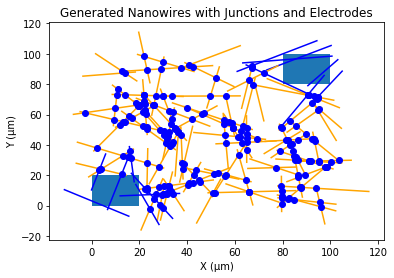

In [5]:
class Electrode:
    
    def __init__(self, x, y, width, height):
        self.x = x; self.y = y
        self.width = width; self.height = height
        self.nanowires = []
        self.voltage = 0
        
def connect_electrodes(electrodes, network):
    """Takes array of Electrode and array of Nanowire ; adds intersecting Nanowire indices to electrodes."""
    for i, electrode in enumerate(electrodes):
        # obtain min and max coordinates for bouding box
        exmin = electrode.x; exmax = electrode.x + electrode.width
        eymin = electrode.y; eymax = electrode.y + electrode.height
        for j, nanowire in enumerate(network):
            # obtain min and max coordinates for bouding box
            nxmin = min(nanowire.x1, nanowire.x2); nymin = min(nanowire.y1, nanowire.y2)
            nxmax = max(nanowire.x1, nanowire.x2); nymax = max(nanowire.y1, nanowire.y2)
            # and get start and end points (not necessarily the min/max box corners) with shorter names
            nx1 = nanowire.x1; ny1 = nanowire.y1
            nx2 = nanowire.x2; ny2 = nanowire.y2
            if nxmax >= exmin and nxmin <= exmax:
                if nymax >= eymin and nymin <= eymax:
                    rectpoints = [(exmin, eymin), (exmin, eymax), (exmax, eymin), (exmax, eymax)]
                    gtz = False; ltz = False
                    for point in rectpoints: # determine whether rectangle overlaps line by corners
                        x3, y3 = point
                        sign = (nx2-nx1)*(y3-ny1)-(x3-nx1)*(ny2-ny1) # calculate z of cross product of line-line and line-rectpoint vectors
                        if sign < 0: # For the rectangle and line to overlap, at least one point should have a negative cross product,
                            ltz = True
                        if sign > 0: # and at least one point should have the opposite (positive).
                            gtz = True
                    if gtz and ltz: # there's a rectangle corner on each side of the line, so they intersect
                        electrode.nanowires.append(j)

electrodes = [Electrode(0, 0, 20, 20), Electrode(80, 80, 20, 20)]
network = spawn_nanowires()
connect_electrodes(electrodes, network)
junctions = create_junctions(network, electrodes=electrodes)
for i, nanowire in enumerate(network):
    color = 'orange'
    for electrode in electrodes:
        if i in electrode.nanowires:
            color = 'blue'
            break
    pyplot.plot([nanowire.x1, nanowire.x2], [nanowire.y1, nanowire.y2], color=color)
for junction in junctions:
    pyplot.plot([junction.x], [junction.y], 'bo')
for electrode in electrodes:
    pyplot.gca().add_patch(patches.Rectangle((electrode.x, electrode.y), electrode.width, electrode.height))
pyplot.title("Generated Nanowires with Junctions and Electrodes")
pyplot.xlabel("X (µm)")
pyplot.ylabel("Y (µm)")
pyplot.show()

To make this plotting easier, automate it:

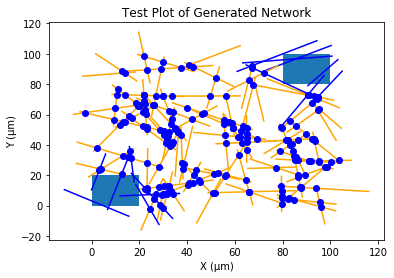

In [6]:
def plot_network(nanowires, junctions, electrodes, title):
    for i, nanowire in enumerate(nanowires):
        color = 'orange'
        for electrode in electrodes:
            if i in electrode.nanowires:
                color = 'blue'
                break
        pyplot.plot([nanowire.x1, nanowire.x2], [nanowire.y1, nanowire.y2], color=color)
    for junction in junctions:
        pyplot.plot([junction.x], [junction.y], 'bo')
    for electrode in electrodes:
        pyplot.gca().add_patch(patches.Rectangle((electrode.x, electrode.y), electrode.width, electrode.height))
    pyplot.title(title)
    pyplot.xlabel("X (µm)")
    pyplot.ylabel("Y (µm)")
    pyplot.show()
    
electrodes = [Electrode(0, 0, 20, 20), Electrode(80, 80, 20, 20)]
nanowires = spawn_nanowires()
connect_electrodes(electrodes, nanowires)
junctions = create_junctions(nanowires, electrodes=electrodes)
plot_network(nanowires, junctions, electrodes, "Test Plot of Generated Network")

Finally, run a simple experiment. Compare the number of junctions to the number of nanowires.

Consider any two nanowires. Because they are independently, randomly, and uniformly positioned, there is a constant probability any two nanowires will collide to form a junction. Thus, the number of junctions should be proportional to the number of pairs of nanowires, which, for a number of nanowires $N$, is
$$\frac{N^2-N}{2}.$$
For large $N$, $N^2\gg N$, so this means the number of junctions $J$ has, approximately, $J\propto N$.

Support this by experiment:

Calculating numbers 0...
Calculating numbers 100...
Calculating numbers 200...


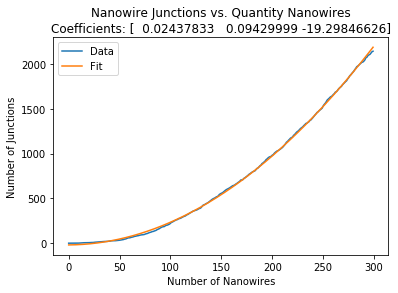

In [7]:
numbers = [] # numbers of nanowires
num_junctions = [] # numbers of junctions

for number in range(300):
    if number%100 == 0:
        print("Calculating numbers {}...".format(number))
    numbers.append(number)
    nanowires = []
    junctions = []
    nanowires = spawn_nanowires(number)
    junctions = create_junctions(nanowires)
    num_junctions.append(len(junctions))
    
coefficients = numpy.polyfit(numbers, num_junctions, 2)
fit_curve = numpy.poly1d(coefficients)
pyplot.plot(numbers, num_junctions, label='Data')
pyplot.plot(numbers, fit_curve(numbers), label='Fit')
pyplot.title("Nanowire Junctions vs. Quantity Nanowires\nCoefficients: {}".format(coefficients))
pyplot.xlabel("Number of Nanowires")
pyplot.ylabel("Number of Junctions")
pyplot.legend()
pyplot.show()

...and the curve fits well. Theory holds up. So far so good.

Furthermore, for similar reasons, the number of junctions per nanowire should scale linearly with the number of nanowires. Support this, too, by experiment:

Calculating numbers 0...
Calculating numbers 100...
Calculating numbers 200...


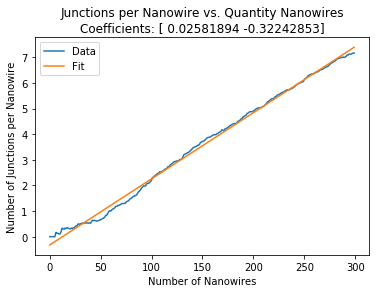

In [8]:
numbers = [] # numbers of nanowires
num_junctions_per = [] # numbers of junctions

for number in range(300):
    if number%100 == 0:
        print("Calculating numbers {}...".format(number))
    numbers.append(number)
    nanowires = []
    junctions = []
    nanowires = spawn_nanowires(number)
    junctions = create_junctions(nanowires)
    num_junctions_per.append(len(junctions)/max(len(nanowires),1))
    
coefficients = numpy.polyfit(numbers, num_junctions_per, 1)
fit_curve = numpy.poly1d(coefficients)
pyplot.plot(numbers, num_junctions_per, label='Data')
pyplot.plot(numbers, fit_curve(numbers), label='Fit')
pyplot.title("Junctions per Nanowire vs. Quantity Nanowires\nCoefficients: {}".format(coefficients))
pyplot.xlabel("Number of Nanowires")
pyplot.ylabel("Number of Junctions per Nanowire")
pyplot.legend()
pyplot.show()

Both these correlations are straightforward and should apply with any distribution of nanowire lengths.

Now let's try to find the type of network graph (scale free? random?).

Calculating numbers 0...
Calculating numbers 100...
Calculating numbers 200...


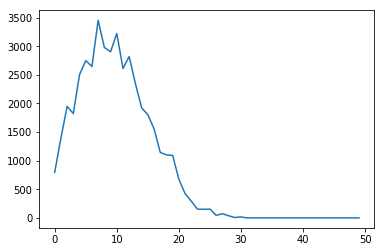

In [9]:
numbers = [] # numbers of nanowires
num_junctions_per = [] # numbers of junctions

jnumbers = []
number_junctions = []

for n in range(50):
    jnumbers.append(n)
    number_junctions.append(0)
        
for number in range(300):
    if number%100 == 0:
        print("Calculating numbers {}...".format(number))
    numbers.append(number)
    nanowires = []
    junctions = []
    nanowires = spawn_nanowires(number)
    junctions = create_junctions(nanowires)
    num_junctions_per.append(len(junctions)/max(len(nanowires),1))
    
    for nanowire in nanowires:
        number_junctions[len(nanowire.junctions)] += 1
 
"""
coefficients = numpy.polyfit(numbers, num_junctions_per, 1)
fit_curve = numpy.poly1d(coefficients)
pyplot.plot(numbers, num_junctions_per, label='Data')
pyplot.plot(numbers, fit_curve(numbers), label='Fit')
pyplot.title("Junctions per Nanowire vs. Quantity Nanowires\nCoefficients: {}".format(coefficients))
pyplot.xlabel("Number of Nanowires")
pyplot.ylabel("Number of Junctions per Nanowire")
pyplot.legend()
pyplot.show()
"""

   
pyplot.plot(jnumbers, number_junctions)
pyplot.show()

Hm. Not quite power law?

Next, implement some circuit solving to simulate the network. Begin by focusing on a single junction---a simple system.

Assume the junctions is modelled by a gap in which a conductive ion bridge can grow, governed by the equations

$$V=\left[R_{on}\cdot\frac{w}{w_0} + R_{off}\cdot\left(\frac{w}{w_0}\right)\right]\cdot I$$

and

$$ \frac{dw}{dt} = \left[\mu_v\cdot\frac{R_{on}}{w_0}\cdot I\right]\cdot\Omega - \tau\cdot(w-w_0)+\eta, $$

where $V$ is the voltage across the junction, $I$ is the current through the junction, $w_0$ is the width of the junction, $w$, for $w\in[0, w_0]$, is the current width of the ion bridge across the junction, $R_{on}$ and $R_{off}$ are the resistances of the ion bridge and empty gap, respectively, $\mu_v$ is an ionic mobility constant, $\tau$ is a dissolution time constant that represents the spontaneous dissolution of the ion bridge when unforced, $\Omega$ is the windowing function

$$\Omega=\frac{w\cdot(w_0-w)}{w_0^2}$$

to represent some nonlinearity, and $\eta$ is noise representing ion availability with

$$\eta=\alpha\cdot\Delta w,$$

where $\alpha$ is a normal random variable and $\Delta w$ is approximately $\frac{dw}{dt}$ (it does not have to solved for simultaneously).

Simulation will proceed in the following steps:

- Apply voltages to electrodes
- Create a linear system to solve for unknown voltages/currents given junction resistances
- Using calculated currents, update junction resistances
- Repeat

Eventually, this will be automatic. For now, for testing and because only one junction is considered, do this manually:

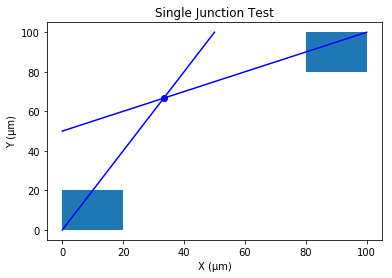

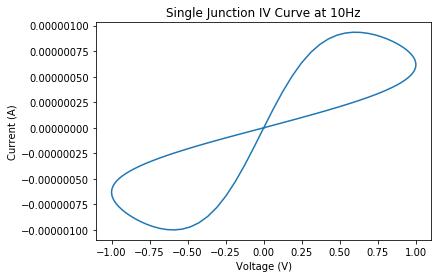

In [17]:
# create network
nanowires = [Nanowire((0,0),(50, 100)), Nanowire((100,100), (0, 50))]
junctions = []
electrodes = [Electrode(0, 0, 20, 20), Electrode(80, 80, 20, 20)]
connect_electrodes(electrodes, nanowires)
junctions = create_junctions(nanowires, electrodes=electrodes)
junctions[0].alpha_sigma = 0
plot_network(nanowires, junctions, electrodes, "Single Junction Test")
        
# simulate sinusoidal input
times = []
voltages = []
currents = []
frequency = 10 # Hz
amplitude = 1 # V (0 to peak)
timestep = 0.001 # 1 ms
current_time = 0
while current_time <= 1/frequency+timestep:
    # set known voltages
    electrodes[0].voltage = 0
    electrodes[1].voltage = amplitude*math.sin(current_time*frequency*2*math.pi)
    for nw_index in electrodes[0].nanowires:
        nanowires[nw_index].voltage = electrodes[0].voltage
    for nw_index in electrodes[1].nanowires:
        nanowires[nw_index].voltage = electrodes[1].voltage
    # solve for currents
    junctions[0].current = (nanowires[1].voltage - nanowires[0].voltage) / junctions[0].resistance()
    # store data
    times.append(current_time)
    voltages.append(electrodes[1].voltage)
    currents.append(junctions[0].current)
    junctions[0].update_w(timestep)
    current_time += timestep
    
pyplot.plot(voltages, currents)
pyplot.xlabel('Voltage (V)')
pyplot.ylabel('Current (A)')
pyplot.title('Single Junction IV Curve at 10Hz')
pyplot.show()

Well, that's definitely a memristor. So far so good.

Experimentation reveals, though, that this only makes a pretty curve---the trademark of the memristor---at certain voltage/frequency combinations, e.g., 10 Hz / 1 V or 100 Hz / 10 V. Contemplation reveals the system has two asymptotes: $R_{on}$ and $R_{off}$. When the voltage is low, the ion bridge never forms and the system emulates a resistor with $R_{off}$. When the voltage is high, the bridge forms instantaneously and the system acts as $R_{on}$. Occasionally, with high voltage, numerical simulation accuracy loss gives incorrect aperiodic results (i.e., switching to then remaining at the $R_{on}$ state). It can be concluded that the neuromorphic network probably works best at certain frequencies and voltages, where too high a voltage may result in error.

Next, implement noise.

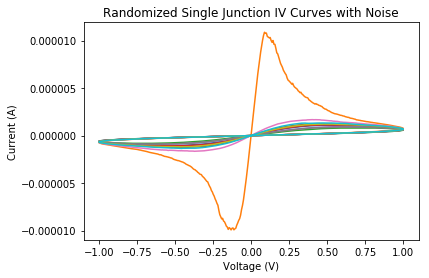

In [12]:
for i in range(10):
    
    # create network
    nanowires = [Nanowire((0,0),(50, 100)), Nanowire((100,100), (0, 50))]
    junctions = []
    electrodes = [Electrode(0, 0, 20, 20), Electrode(80, 80, 20, 20)]
    connect_electrodes(electrodes, nanowires)
    # ron=5e3, roffron=1e3, wmax=5e-9, mobility=0.5e-12, dissolution_rate=1e-2, roffron_sigma=0, wmax_sigma=0, alpha_sigma=0))
    junctions = create_junctions(nanowires, electrodes=electrodes, roffron_sigma=0.05, wmax_sigma=0.01, alpha_sigma=0.3, seed=i)

    # simulate sinusoidal input
    times = []
    voltages = []
    currents = []
    frequency = 10 # Hz
    amplitude = 1 # V (0 to peak)
    timestep = 0.0001 # 0.1 ms
    current_time = 0
    while current_time <= 1/frequency+timestep:
        # set known voltages
        electrodes[0].voltage = 0
        electrodes[1].voltage = amplitude*math.sin(current_time*frequency*2*math.pi)
        for nw_index in electrodes[0].nanowires:
            nanowires[nw_index].voltage = electrodes[0].voltage
        for nw_index in electrodes[1].nanowires:
            nanowires[nw_index].voltage = electrodes[1].voltage
        # solve for currents
        junctions[0].current = (nanowires[1].voltage - nanowires[0].voltage) / junctions[0].resistance()
        # store data
        times.append(current_time)
        voltages.append(electrodes[1].voltage)
        currents.append(junctions[0].current)
        junctions[0].update_w(timestep)
        current_time += timestep

    pyplot.plot(voltages, currents)
    
pyplot.xlabel('Voltage (V)')
pyplot.ylabel('Current (A)')
pyplot.title('Randomized Single Junction IV Curves with Noise')
pyplot.show()

That works, but experimentation shows the system is very sensitive to noise. Network parameters may have to be chosen very carefully.

Next, test automatic ion bridge dissolution.

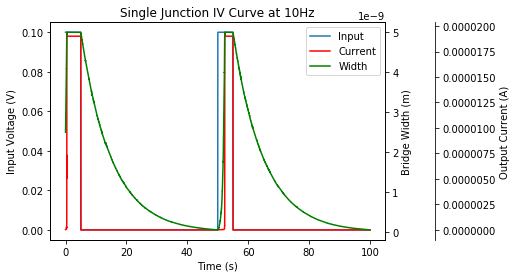

In [13]:
# create network
nanowires = [Nanowire((0,0),(50, 100)), Nanowire((100,100), (0, 50))]
junctions = []
electrodes = [Electrode(0, 0, 20, 20), Electrode(80, 80, 20, 20)]
connect_electrodes(electrodes, nanowires)
junctions = create_junctions(nanowires, electrodes=electrodes, alpha_sigma=1)
        
# simulate sinusoidal input
times = []
voltages = []
inputs = []
currents = []
ws = []
timestep = 0.0001 # 1 ms
current_time = 0
def input_function(t):
    """Define input voltage"""
    if t < 5:
        return 0.1 # V
    if t < 50:
        return 0 # V
    if t < 55:
        return 0.1 # V
    return 0 # V
    
while current_time <= 100: # run for 2 s
    # set known voltages
    electrodes[0].voltage = 0
    electrodes[1].voltage = input_function(current_time)
    inputs.append(input_function(current_time))
    for nw_index in electrodes[0].nanowires:
        nanowires[nw_index].voltage = electrodes[0].voltage
    for nw_index in electrodes[1].nanowires:
        nanowires[nw_index].voltage = electrodes[1].voltage
    # solve for currents
    junctions[0].current = (nanowires[1].voltage - nanowires[0].voltage) / junctions[0].resistance()
    # store data
    times.append(current_time)
    voltages.append(electrodes[1].voltage)
    currents.append(junctions[0].current)
    ws.append(junctions[0].w)
    junctions[0].update_w(timestep)
    current_time += timestep
    
fig = pyplot.figure()
host = fig.add_subplot(111)
p1, = host.plot(times, inputs, label='Input')
outputs = host.twinx()
p2, = outputs.plot(times, currents, color="red", label='Current')
outputs.set_ylabel('Output Current (A)')
widths = host.twinx()
p3, = widths.plot(times, ws, color="green", label="Width")
widths.set_ylabel('Bridge Width (m)')
outputs.spines['right'].set_position(('outward', 50))
host.set_xlabel('Time (s)')
host.set_ylabel('Input Voltage (V)')
host.set_title('Single Junction IV Curve at 10Hz')
host.legend(handles=[p1, p2, p3])
pyplot.show(host)

Those are very sharp state changes. This is probably caused by the large resistance gap:

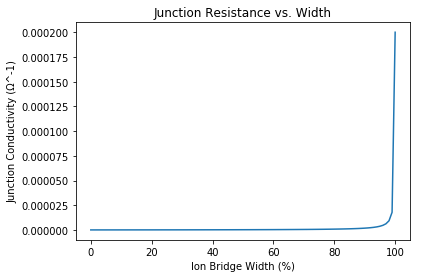

In [14]:
widths = []
resistances = []
junction = Junction((0,0), 0, 0, ron=5e3, roffron=1e3, wmax=5e-9, mobility=0.5e-12, dissolution_rate=1e-1, roffron_sigma=0, wmax_sigma=0, alpha_sigma=0)
for width in numpy.linspace(0, 100, 100):
    junction.w = junction.wmax*width/100
    widths.append(width)
    resistances.append(1/junction.resistance())

pyplot.plot(widths, resistances)
pyplot.xlabel('Ion Bridge Width (%)')
pyplot.ylabel('Junction Conductivity (Ω^-1)')
pyplot.title('Junction Resistance vs. Width')
pyplot.show()

Yep.

Next, implement a two-junction system. This will lay most of the groundwork for scaleable simultaneous equation solving.

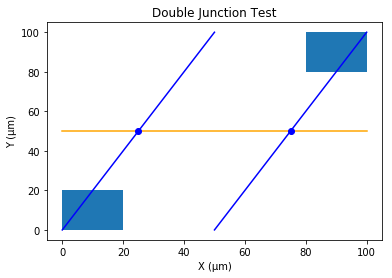

[[  1.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.00000000e+00   0.00000000e+00]
 [ -6.81689316e-07  -2.00951168e-07   8.82640484e-07]]
[ 0.  1.  0.]
[ -8.95373516e-17   1.00000000e+00   2.27670463e-01]


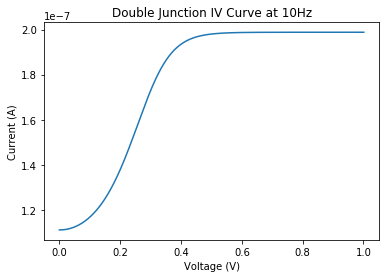

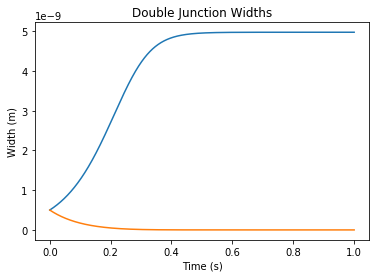

In [15]:
def calculate_current_from_electrode(electrode, nanowires, junctions):
    # if the voltage at an electrode is higher than the voltage away from the electrode, then there will be positive current flowing away from it
    # the current through a junction is recorded as (voltage[1]-voltage[0])/resistance
    # so if the electrode is at voltage[1], the current through the junction should be added to the total sum of current from the electrode
    current = 0
    for i in electrode.nanowires:
        nanowire = nanowires[i]
        for j in nanowire.junctions:
            junction = junctions[j]
            if junction.nanowires[0] == i:
                current -= junction.current
            else:
                current += junction.current
    return current

# create network
nanowires = [Nanowire((0,0),(50, 100)), Nanowire((100,100), (50, 0)), Nanowire((0, 50), (100,50))]
junctions = []
electrodes = [Electrode(0, 0, 20, 20), Electrode(80, 80, 20, 20)]
connect_electrodes(electrodes, nanowires)
junctions = create_junctions(nanowires, electrodes=electrodes)
junctions[0].w = junctions[0].wmax*0.1
junctions[1].w = junctions[1].wmax*0.1
junctions[0].nanowires = [0, 2]
junctions[1].nanowires = [1, 2]
plot_network(nanowires, junctions, electrodes, "Double Junction Test")

# simulate sinusoidal input
times = []
voltages = []
currents = []
w0 = []
w1 = []
frequency = 10 # Hz
amplitude = 1 # V (0 to peak)
timestep = 0.0001 # 1 ms
current_time = 0
flag = False
while current_time <= (1/frequency+timestep)*10:

    # set known voltages
    electrodes[0].voltage = 0
    electrodes[1].voltage = amplitude#*math.sin(current_time*frequency*2*math.pi)

    # calculate voltages
    array = numpy.zeros((len(nanowires), len(nanowires))) # create an n by n+1 array
    weights = numpy.zeros(len(nanowires))
    for i, nanowire in enumerate(nanowires):
        for electrode in electrodes:
            if i in electrode.nanowires:
                array[i][i] = 1
                weights[i] = electrode.voltage
                break
        else:
            for j in nanowire.junctions:
                resistance = junctions[j].resistance()
                othernanowire = junctions[j].nanowires[(junctions[j].nanowires.index(i)+1)%2]
                array[i][i] += 1/resistance
                array[i][othernanowire] -= 1/resistance
    solution = numpy.linalg.lstsq(array, weights)[0]
    for i in range(len(nanowires)):
        nanowires[i].voltage = solution[i]

    # solve for currents
    for i in range(len(junctions)):
        ns = junctions[i].nanowires
        junctions[i].current = (nanowires[ns[1]].voltage - nanowires[ns[0]].voltage) / junctions[i].resistance()
        junctions[i].update_w(timestep)
        
    if flag == False and current_time > (1/frequency+timestep)*2.5:
        flag = True
        print(array)
        print(weights)
        print(solution)

    # store data
    times.append(current_time)
    voltages.append(electrodes[1].voltage)
    currents.append(calculate_current_from_electrode(electrodes[1], nanowires, junctions))
    w0.append(junctions[0].w)
    w1.append(junctions[1].w)
    current_time += timestep
    
#pyplot.plot(voltages, currents)
pyplot.plot(times, currents)
pyplot.xlabel('Voltage (V)')
pyplot.ylabel('Current (A)')
pyplot.title('Double Junction IV Curve at 10Hz')
pyplot.show()
pyplot.plot(times, w0)
pyplot.plot(times, w1)
pyplot.xlabel('Time (s)')
pyplot.ylabel('Width (m)')
pyplot.title('Double Junction Widths')
pyplot.show()

The junctions have asymmetry, thus the opposite behavior of the junctions. I don't like it, but I don't see an immediate solution. I'll think about it.

It is time to attempt to replicate simple results of "A theoretical and experimental study of neuromorphic atomic switch networks for reservoir computing" (Gimzerwski et al. 2013).

In [19]:
def update_network(nanowires, junctions, electrodes, timestep):
    # calculate voltages
    array = numpy.zeros((len(nanowires), len(nanowires))) # create an n by n+1 array
    weights = numpy.zeros(len(nanowires))
    for i, nanowire in enumerate(nanowires):
        for electrode in electrodes:
            if i in electrode.nanowires:
                array[i][i] = 1
                weights[i] = electrode.voltage
                break
        else:
            for j in nanowire.junctions:
                resistance = junctions[j].resistance()
                othernanowire = junctions[j].nanowires[(junctions[j].nanowires.index(i)+1)%2]
                array[i][i] += 1/resistance
                array[i][othernanowire] -= 1/resistance
    solution = numpy.linalg.lstsq(array, weights)[0]
    for i in range(len(nanowires)):
        nanowires[i].voltage = solution[i]
       
    # solve for currents
    for i in range(len(junctions)):
        ns = junctions[i].nanowires
        junctions[i].current = (nanowires[ns[1]].voltage - nanowires[ns[0]].voltage) / junctions[i].resistance()
        junctions[i].update_w(timestep)

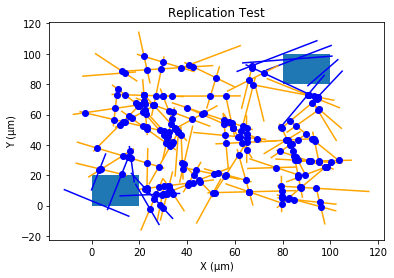

Running simulation...
Simulation complete.


In [27]:
# create network
nanowires = spawn_nanowires()
electrodes = [Electrode(0, 0, 20, 20), Electrode(80, 80, 20, 20)]
connect_electrodes(electrodes, nanowires)
junctions = create_junctions(nanowires, electrodes=electrodes, w0=0.2, dissolution_rate=0.1)
if amplitude == 1:
    plot_network(nanowires, junctions, electrodes, "Replication Test")
# simulate sinusoidal input
times = []
voltages = []
currents = []
jweights = []
jcurrents = []
for junction in junctions:
    jweights.append([])
    jcurrents.append([])
amplitude = 1 #v
frequency = 0.3 # Hz
timestep = 0.001 # 1 ms
current_time = 0
total_time = 5 #s
count = 0
print('Running simulation...')
while current_time <= total_time:
    #if(count % 100 == 0):
    #    print('{}s / {}s...'.format(total_time, current_time))
    count += 1

    # set known voltages
    electrodes[0].voltage = 0 
    electrodes[1].voltage = amplitude#*math.sin(current_time*frequency*2*math.pi)

    update_network(nanowires, junctions, electrodes, timestep)

    # store data
    times.append(current_time)
    voltages.append(electrodes[1].voltage)
    for i in range(len(junctions)):
        jweights[i].append(junctions[i].w)
        jcurrents[i].append(junctions[i].current)
    current = calculate_current_from_electrode(electrodes[1], nanowires, junctions)
    currents.append(current)
    current_time += timestep

print('Simulation complete.')

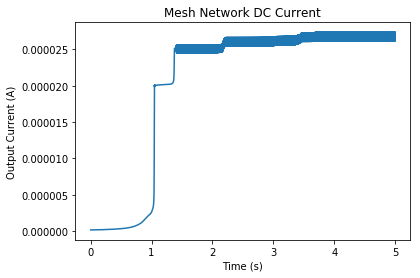

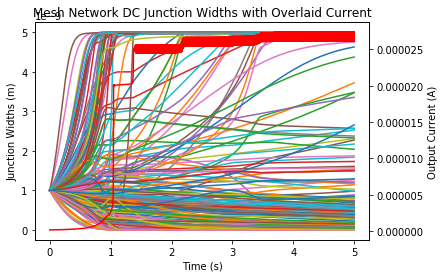

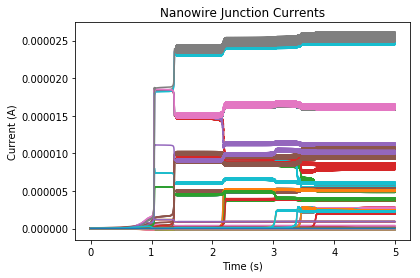

In [28]:
pyplot.plot(times, currents)
pyplot.ylabel('Output Current (A)')
pyplot.xlabel('Time (s)')
pyplot.title('Mesh Network DC Current')
pyplot.show(host)

fig = pyplot.figure()
host = fig.add_subplot(111)
for i in range(len(junctions)):
    host.plot(times, jweights[i])
outputs = host.twinx()
outputs.plot(times, currents, color="red")
outputs.set_ylabel('Output Current (A)')
#outputs.spines['right'].set_position(('outward', 50))
host.set_xlabel('Time (s)')
host.set_ylabel('Junction Widths (m)')
host.set_title('Mesh Network DC Junction Widths with Overlaid Current')
pyplot.show(host)

for i in range(len(junctions)):
    pyplot.plot(times, jcurrents[i])
pyplot.title("Nanowire Junction Currents")
pyplot.xlabel('Time (s)')
pyplot.ylabel('Current (A)')
pyplot.show()

Okay, that looks about right...

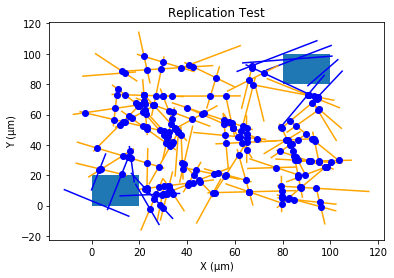

Running simulation...
Simulation complete.


In [143]:
# create network
nanowires = spawn_nanowires()
electrodes = [Electrode(0, 0, 20, 20), Electrode(80, 80, 20, 20)]
connect_electrodes(electrodes, nanowires)
junctions = create_junctions(nanowires, electrodes=electrodes, w0=0.2)
if amplitude == 1:
    plot_network(nanowires, junctions, electrodes, "Replication Test")
# simulate sinusoidal input
times = []
voltages = []
currents = []
jweights = []
jcurrents = []
for junction in junctions:
    jweights.append([])
    jcurrents.append([])
amplitude = 1 #v
frequency = 0.1 # Hz
timestep = 0.001 # 1 ms
current_time = 0
total_time = 20 #s
count = 0
print('Running simulation...')
while current_time <= total_time:
    #if(count % 100 == 0):
    #    print('{}s / {}s...'.format(total_time, current_time))
    count += 1

    # set known voltages
    electrodes[0].voltage = 0 
    electrodes[1].voltage = amplitude*(math.sin(current_time*frequency*2*math.pi)+1)/2

    update_network(nanowires, junctions, electrodes, timestep)

    # store data
    times.append(current_time)
    voltages.append(electrodes[1].voltage)
    for i in range(len(junctions)):
        jweights[i].append(junctions[i].w)
        jcurrents[i].append(junctions[i].current)
    current = calculate_current_from_electrode(electrodes[1], nanowires, junctions)
    currents.append(current)
    current_time += timestep

print('Simulation complete.')

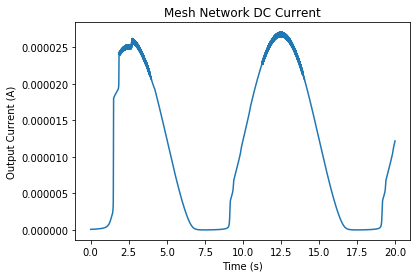

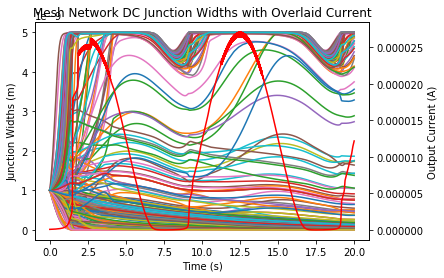

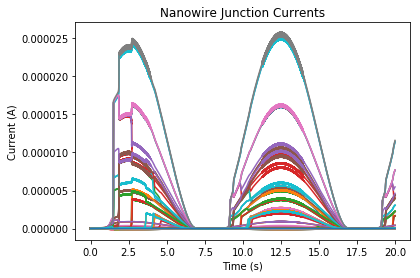

In [144]:
pyplot.plot(times, currents)
pyplot.ylabel('Output Current (A)')
pyplot.xlabel('Time (s)')
pyplot.title('Mesh Network DC Current')
pyplot.show(host)

fig = pyplot.figure()
host = fig.add_subplot(111)
for i in range(len(junctions)):
    host.plot(times, jweights[i])
outputs = host.twinx()
outputs.plot(times, currents, color="red")
outputs.set_ylabel('Output Current (A)')
#outputs.spines['right'].set_position(('outward', 50))
host.set_xlabel('Time (s)')
host.set_ylabel('Junction Widths (m)')
host.set_title('Mesh Network DC Junction Widths with Overlaid Current')
pyplot.show(host)

for i in range(len(junctions)):
    pyplot.plot(times, jcurrents[i])
pyplot.title("Nanowire Junction Currents")
pyplot.xlabel('Time (s)')
pyplot.ylabel('Current (A)')
pyplot.show()

Hm. This works, but running simulations is slow. If I can speed this up about ten times or more, data collection will be much easier. Two to three orders of magnitude would be wonderful.